# MNIST Experiment Results Analysis

Analyze MNIST federated learning experiment results with paper-ready visualizations.

**Usage**: Set the `experiment_path` variable to point to your experiment directory.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Set plotting parameters for paper-ready figures
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.dpi"] = 100

## Configure Experiment Path

In [3]:
# SET YOUR EXPERIMENT PATH HERE
experiment_path = "../../../results/mnist-experiment-1"
experiment_path = "/Users/pedrogbr/Downloads/rounds_130_seed_777_topology_star_training_ray_actor_pool_size_4_580bb5"

# Convert to Path object
exp_path = Path(experiment_path)

# Check if path exists
if exp_path.exists():
    print(f"✓ Experiment path found: {exp_path.absolute()}")

    # List available files
    files = list(exp_path.glob("*"))
    print(f"\nFiles in experiment directory:")
    for f in files[:10]:  # Show first 10 files
        print(f"  - {f.name}")
    if len(files) > 10:
        print(f"  ... and {len(files) - 10} more files")
else:
    print(f"✗ Experiment path not found: {exp_path}")
    print("Please update the 'experiment_path' variable to point to your experiment directory.")

✓ Experiment path found: /Users/pedrogbr/Downloads/rounds_130_seed_777_topology_star_training_ray_actor_pool_size_4_580bb5

Files in experiment directory:
  - messages.csv
  - system_resources.csv
  - config.yaml
  - execution_time.csv
  - global_metrics.csv


## Load Experiment Data

In [4]:
# Function to load metrics from experiment path
def load_experiment_metrics(exp_path):
    """Load metrics from experiment directory."""
    metrics_file = exp_path / "global_metrics.csv"

    if not metrics_file.exists():
        print(f"Warning: global_metrics.csv not found in {exp_path}")
        return pd.DataFrame()

    try:
        df = pd.read_csv(metrics_file)
        return df
    except Exception as e:
        print(f"Error loading metrics: {e}")
        return pd.DataFrame()


# Load the metrics
df_metrics = load_experiment_metrics(exp_path)

if not df_metrics.empty:
    print(f"✓ Loaded {len(df_metrics)} records")
    print(f"\nMetrics available: {df_metrics['metric'].unique().tolist()}")
    print(f"Rounds: {df_metrics['round'].min()} - {df_metrics['round'].max()}")
    print(f"Number of nodes: {df_metrics['node'].nunique()}")
    print(f"Nodes: {sorted(df_metrics['node'].unique())}")
else:
    print("No metrics data loaded. Please check your experiment path.")

✓ Loaded 1056 records

Metrics available: ['test_loss', 'test_metric']
Rounds: 0 - 130
Number of nodes: 8
Nodes: ['node', 'node_1', 'node_2', 'node_3', 'node_4', 'node_5', 'node_6', 'node_7']


## Process Metrics Data

In [5]:
# Process the metrics data
if not df_metrics.empty:
    # Identify the correct metric names for loss and accuracy
    # Common metric names in P2PFL:
    loss_metrics = ["loss", "train_loss", "test_loss"]
    acc_metrics = ["accuracy", "acc", "test_accuracy", "test_acc", "test_metric", "compile_metrics"]

    # Find which metrics are available
    available_metrics = df_metrics["metric"].unique()
    loss_metric = None
    acc_metric = None

    for metric in loss_metrics:
        if metric in available_metrics:
            loss_metric = metric
            break

    for metric in acc_metrics:
        if metric in available_metrics:
            acc_metric = metric
            break

    print(f"Using loss metric: {loss_metric}")
    print(f"Using accuracy metric: {acc_metric}")

    # Calculate average metrics per round
    avg_loss = pd.DataFrame()
    avg_accuracy = pd.DataFrame()

    if loss_metric:
        loss_df = df_metrics[df_metrics["metric"] == loss_metric]
        avg_loss = loss_df.groupby("round")["value"].agg(["mean", "std", "count"]).reset_index()
        avg_loss.columns = ["round", "mean", "std", "count"]
        avg_loss = avg_loss.sort_values("round")
        print(f"\nLoss data: {len(avg_loss)} rounds")

    if acc_metric:
        acc_df = df_metrics[df_metrics["metric"] == acc_metric]
        avg_accuracy = acc_df.groupby("round")["value"].agg(["mean", "std", "count"]).reset_index()
        avg_accuracy.columns = ["round", "mean", "std", "count"]
        avg_accuracy = avg_accuracy.sort_values("round")
        print(f"Accuracy data: {len(avg_accuracy)} rounds")

Using loss metric: test_loss
Using accuracy metric: test_metric

Loss data: 131 rounds
Accuracy data: 131 rounds


## Main Visualization: Loss and Accuracy Evolution

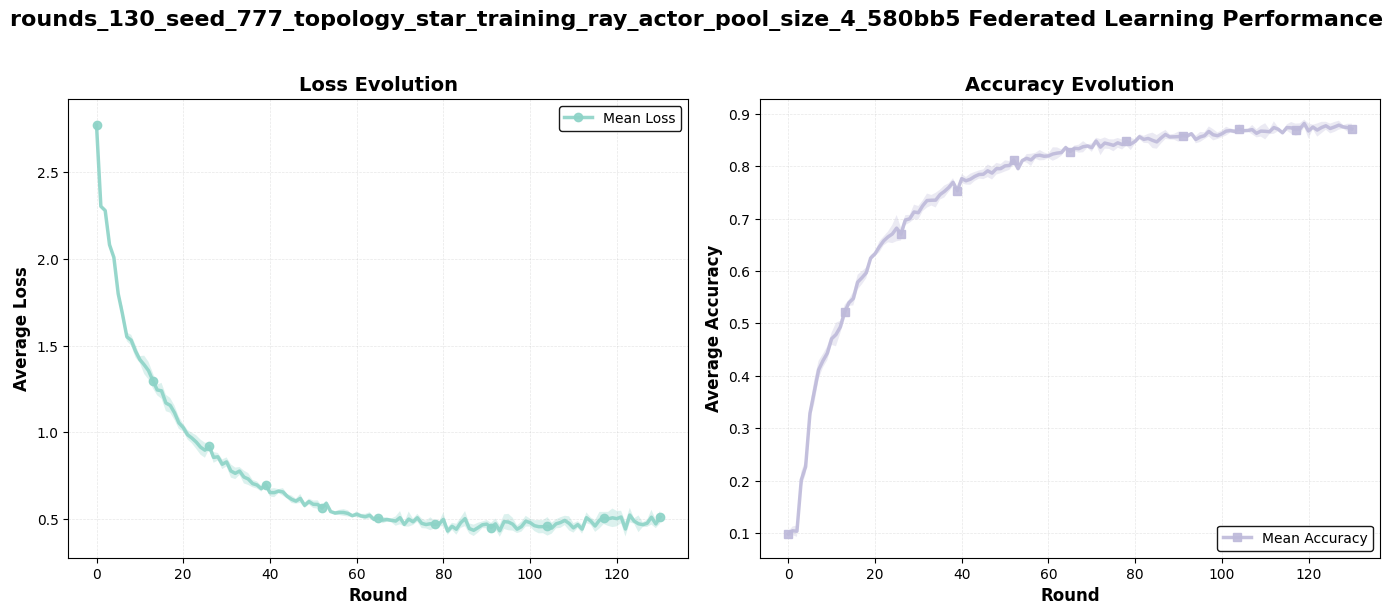

In [6]:
# Combined plot with MNIST grid styling
if not df_metrics.empty and not avg_loss.empty and not avg_accuracy.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Define colors from colormap
    colors = plt.cm.Set3(np.linspace(0, 1, 10))

    # Loss plot
    ax1.plot(
        avg_loss["round"],
        avg_loss["mean"],
        color=colors[0],
        linewidth=2.5,
        marker="o",
        markersize=6,
        markevery=max(1, len(avg_loss) // 10),
        label="Mean Loss",
        alpha=0.9,
    )

    # Add shaded area for std deviation
    ax1.fill_between(
        avg_loss["round"],
        avg_loss["mean"] - avg_loss["std"],
        avg_loss["mean"] + avg_loss["std"],
        alpha=0.3,
        color=colors[0],
        edgecolor="none",
    )

    ax1.set_xlabel("Round", fontsize=12, fontweight="bold")
    ax1.set_ylabel("Average Loss", fontsize=12, fontweight="bold")
    ax1.set_title("Loss Evolution", fontsize=14, fontweight="bold")
    ax1.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
    ax1.legend(loc="upper right", framealpha=0.9, edgecolor="black", fancybox=True)

    # Accuracy plot
    ax2.plot(
        avg_accuracy["round"],
        avg_accuracy["mean"],
        color=colors[2],
        linewidth=2.5,
        marker="s",
        markersize=6,
        markevery=max(1, len(avg_accuracy) // 10),
        label="Mean Accuracy",
        alpha=0.9,
    )

    # Add shaded area for std deviation
    ax2.fill_between(
        avg_accuracy["round"],
        avg_accuracy["mean"] - avg_accuracy["std"],
        avg_accuracy["mean"] + avg_accuracy["std"],
        alpha=0.3,
        color=colors[2],
        edgecolor="none",
    )

    ax2.set_xlabel("Round", fontsize=12, fontweight="bold")
    ax2.set_ylabel("Average Accuracy", fontsize=12, fontweight="bold")
    ax2.set_title("Accuracy Evolution", fontsize=14, fontweight="bold")
    ax2.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
    ax2.legend(loc="lower right", framealpha=0.9, edgecolor="black", fancybox=True)

    # Add experiment name to title
    exp_name = exp_path.name if exp_path.name else "MNIST"
    plt.suptitle(f"{exp_name} Federated Learning Performance", fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()

elif not df_metrics.empty:
    # If we only have one metric, plot it
    if not avg_loss.empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = plt.cm.Set3(np.linspace(0, 1, 10))

        ax.plot(
            avg_loss["round"],
            avg_loss["mean"],
            color=colors[0],
            linewidth=2.5,
            marker="o",
            markersize=6,
            markevery=max(1, len(avg_loss) // 10),
            label="Mean Loss",
            alpha=0.9,
        )

        ax.fill_between(
            avg_loss["round"],
            avg_loss["mean"] - avg_loss["std"],
            avg_loss["mean"] + avg_loss["std"],
            alpha=0.3,
            color=colors[0],
            edgecolor="none",
        )

        ax.set_xlabel("Round", fontsize=12, fontweight="bold")
        ax.set_ylabel("Average Loss", fontsize=12, fontweight="bold")
        ax.set_title("Loss Evolution", fontsize=14, fontweight="bold")
        ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
        ax.legend(loc="upper right", framealpha=0.9, edgecolor="black", fancybox=True)
        plt.tight_layout()
        plt.show()

    elif not avg_accuracy.empty:
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = plt.cm.Set3(np.linspace(0, 1, 10))

        ax.plot(
            avg_accuracy["round"],
            avg_accuracy["mean"],
            color=colors[2],
            linewidth=2.5,
            marker="s",
            markersize=6,
            markevery=max(1, len(avg_accuracy) // 10),
            label="Mean Accuracy",
            alpha=0.9,
        )

        ax.fill_between(
            avg_accuracy["round"],
            avg_accuracy["mean"] - avg_accuracy["std"],
            avg_accuracy["mean"] + avg_accuracy["std"],
            alpha=0.3,
            color=colors[2],
            edgecolor="none",
        )

        ax.set_xlabel("Round", fontsize=12, fontweight="bold")
        ax.set_ylabel("Average Accuracy", fontsize=12, fontweight="bold")
        ax.set_title("Accuracy Evolution", fontsize=14, fontweight="bold")
        ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
        ax.legend(loc="lower right", framealpha=0.9, edgecolor="black", fancybox=True)
        plt.tight_layout()
        plt.show()
else:
    print("No data available for plotting. Please check your experiment path.")

## Individual Node Performance

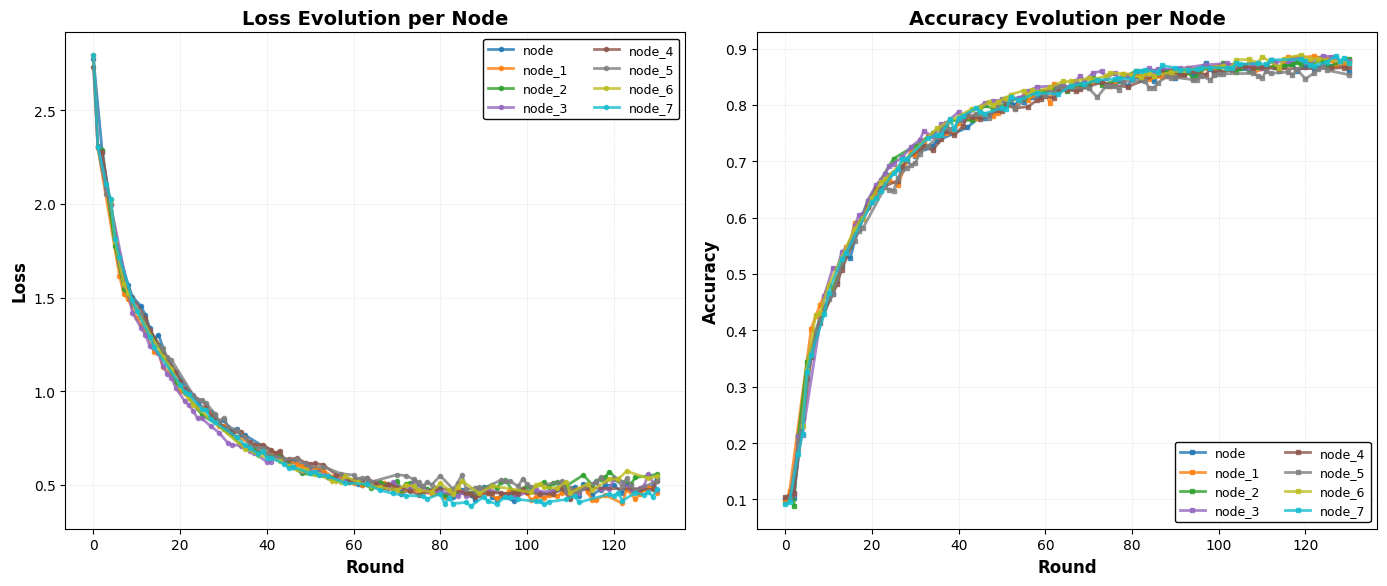

In [7]:
# Plot individual node performance
if not df_metrics.empty:
    # Determine number of subplots needed
    n_plots = 0
    if loss_metric and not df_metrics[df_metrics["metric"] == loss_metric].empty:
        n_plots += 1
    if acc_metric and not df_metrics[df_metrics["metric"] == acc_metric].empty:
        n_plots += 1

    if n_plots > 0:
        fig, axes = plt.subplots(1, n_plots, figsize=(7 * n_plots, 6))
        if n_plots == 1:
            axes = [axes]

        plot_idx = 0

        # Loss per node
        if loss_metric and not df_metrics[df_metrics["metric"] == loss_metric].empty:
            ax = axes[plot_idx]
            loss_df = df_metrics[df_metrics["metric"] == loss_metric]
            nodes = sorted(loss_df["node"].unique(), key=lambda x: int(x.split("-")[-1]) if "-" in x and x.split("-")[-1].isdigit() else x)

            colors = plt.cm.tab10(np.linspace(0, 1, len(nodes)))

            for idx, node in enumerate(nodes):
                node_data = loss_df[loss_df["node"] == node].sort_values("round")
                ax.plot(
                    node_data["round"], node_data["value"], marker="o", markersize=3, label=node, alpha=0.8, linewidth=2, color=colors[idx]
                )

            ax.set_xlabel("Round", fontsize=12, fontweight="bold")
            ax.set_ylabel("Loss", fontsize=12, fontweight="bold")
            ax.set_title("Loss Evolution per Node", fontsize=14, fontweight="bold")
            ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
            ax.legend(loc="best", ncol=min(2, (len(nodes) + 3) // 4), framealpha=0.95, edgecolor="black", fancybox=True, fontsize=9)
            plot_idx += 1

        # Accuracy per node
        if acc_metric and not df_metrics[df_metrics["metric"] == acc_metric].empty:
            ax = axes[plot_idx]
            acc_df = df_metrics[df_metrics["metric"] == acc_metric]
            nodes = sorted(acc_df["node"].unique(), key=lambda x: int(x.split("-")[-1]) if "-" in x and x.split("-")[-1].isdigit() else x)

            colors = plt.cm.tab10(np.linspace(0, 1, len(nodes)))

            for idx, node in enumerate(nodes):
                node_data = acc_df[acc_df["node"] == node].sort_values("round")
                ax.plot(
                    node_data["round"], node_data["value"], marker="s", markersize=3, label=node, alpha=0.8, linewidth=2, color=colors[idx]
                )

            ax.set_xlabel("Round", fontsize=12, fontweight="bold")
            ax.set_ylabel("Accuracy", fontsize=12, fontweight="bold")
            ax.set_title("Accuracy Evolution per Node", fontsize=14, fontweight="bold")
            ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
            ax.legend(loc="best", ncol=min(2, (len(nodes) + 3) // 4), framealpha=0.95, edgecolor="black", fancybox=True, fontsize=9)

        plt.tight_layout()
        plt.show()

## Final Performance Summary

In [8]:
# Summary statistics and final performance
if not df_metrics.empty:
    print("=" * 60)
    print("EXPERIMENT SUMMARY")
    print("=" * 60)
    print(f"Experiment Path: {exp_path.absolute()}")
    print(f"Total Rounds: {df_metrics['round'].max()}")
    print(f"Number of Nodes: {df_metrics['node'].nunique()}")
    print("\n" + "=" * 60)
    print("FINAL PERFORMANCE (Last Round)")
    print("=" * 60)

    last_round = df_metrics["round"].max()

    # Loss statistics
    if loss_metric:
        final_loss = df_metrics[(df_metrics["metric"] == loss_metric) & (df_metrics["round"] == last_round)]["value"]
        if not final_loss.empty:
            print(f"\nLoss Statistics:")
            print(f"  Mean: {final_loss.mean():.6f}")
            print(f"  Std:  {final_loss.std():.6f}")
            print(f"  Min:  {final_loss.min():.6f}")
            print(f"  Max:  {final_loss.max():.6f}")

    # Accuracy statistics
    if acc_metric:
        final_acc = df_metrics[(df_metrics["metric"] == acc_metric) & (df_metrics["round"] == last_round)]["value"]
        if not final_acc.empty:
            print(f"\nAccuracy Statistics:")
            print(f"  Mean: {final_acc.mean():.4f}")
            print(f"  Std:  {final_acc.std():.4f}")
            print(f"  Min:  {final_acc.min():.4f}")
            print(f"  Max:  {final_acc.max():.4f}")

            # Best performing node
            best_node_idx = final_acc.idxmax()
            best_node = df_metrics.loc[best_node_idx, "node"]
            print(f"\n  Best Node: {best_node} ({final_acc.max():.4f})")

            # Worst performing node
            worst_node_idx = final_acc.idxmin()
            worst_node = df_metrics.loc[worst_node_idx, "node"]
            print(f"  Worst Node: {worst_node} ({final_acc.min():.4f})")

    print("\n" + "=" * 60)

EXPERIMENT SUMMARY
Experiment Path: /Users/pedrogbr/Downloads/rounds_130_seed_777_topology_star_training_ray_actor_pool_size_4_580bb5
Total Rounds: 130
Number of Nodes: 8

FINAL PERFORMANCE (Last Round)

Loss Statistics:
  Mean: 0.510414
  Std:  0.037333
  Min:  0.454027
  Max:  0.554855

Accuracy Statistics:
  Mean: 0.8711
  Std:  0.0101
  Min:  0.8536
  Max:  0.8808

  Best Node: node_2 (0.8808)
  Worst Node: node_5 (0.8536)



## Performance Over Time (Optional)

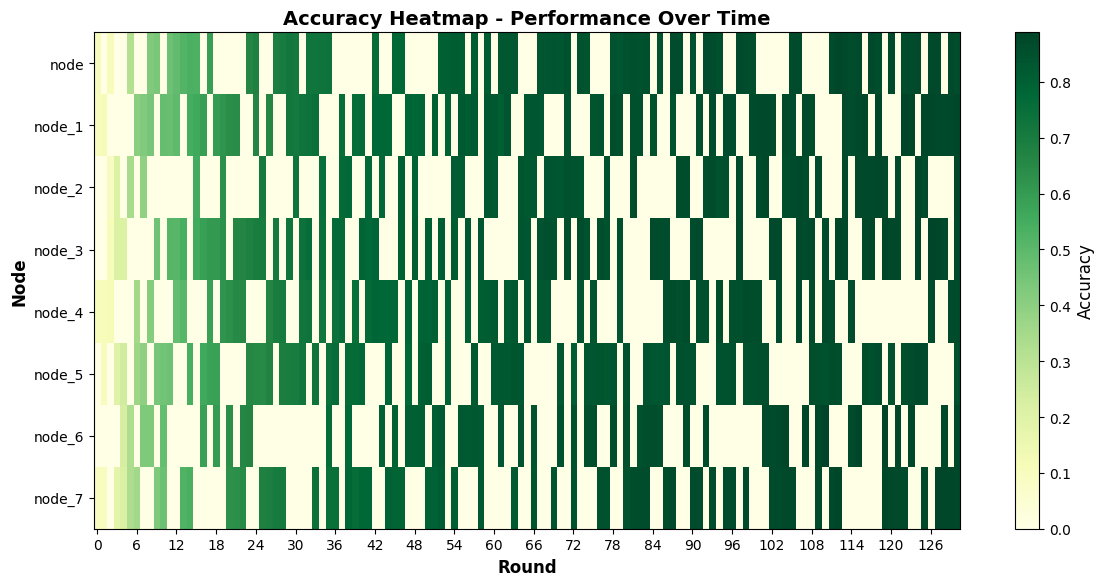

In [9]:
# Create a performance heatmap if there are multiple nodes
if not df_metrics.empty and df_metrics["node"].nunique() > 1:
    if acc_metric and not df_metrics[df_metrics["metric"] == acc_metric].empty:
        import warnings

        warnings.filterwarnings("ignore")

        fig, ax = plt.subplots(figsize=(12, 6))

        # Prepare data for heatmap
        acc_df = df_metrics[df_metrics["metric"] == acc_metric]
        nodes = sorted(acc_df["node"].unique(), key=lambda x: int(x.split("-")[-1]) if "-" in x and x.split("-")[-1].isdigit() else x)
        rounds = sorted(acc_df["round"].unique())

        # Create matrix for heatmap
        acc_matrix = np.zeros((len(nodes), len(rounds)))
        for i, node in enumerate(nodes):
            for j, round_num in enumerate(rounds):
                val = acc_df[(acc_df["node"] == node) & (acc_df["round"] == round_num)]["value"].values
                if len(val) > 0:
                    acc_matrix[i, j] = val[0]

        # Create heatmap
        im = ax.imshow(acc_matrix, aspect="auto", cmap="YlGn", interpolation="nearest")

        # Set ticks
        ax.set_xticks(range(0, len(rounds), max(1, len(rounds) // 20)))
        ax.set_xticklabels([rounds[i] for i in range(0, len(rounds), max(1, len(rounds) // 20))])
        ax.set_yticks(range(len(nodes)))
        ax.set_yticklabels(nodes)

        ax.set_xlabel("Round", fontsize=12, fontweight="bold")
        ax.set_ylabel("Node", fontsize=12, fontweight="bold")
        ax.set_title("Accuracy Heatmap - Performance Over Time", fontsize=14, fontweight="bold")

        plt.colorbar(im, ax=ax, label="Accuracy")
        plt.tight_layout()
        plt.show()